# 2D Flash Multi Echo Sequence for B1 minus mapping.

A simple 2D Gradient Echo (Flash) sequence is used. Images are acquired using the body coil (BC) and a second time with the local receiver coil array (LC). Differnces in signal amplitude between body coil and local coils represent the coil sensitivity profiles of each local coil element.

Initially, the required dependencies are resolved.

In [2]:
import importlib
if importlib.util.find_spec('pypulseq') is None:
    !pip install -q mrzerocore git+https://github.com/imr-framework/pypulseq.git

import math
import numpy as np
import matplotlib.pyplot as plt

import pypulseq as ps

!wget -nc https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py
from utils import animate, simulate_2d, sort_data_implicit, ifft_2d, combine_coils, plot_nd

!pip install -q git+https://github.com/imr-framework/pypulseq.git pymapvbvd
import mapvbvd

from IPython.display import HTML



File ‘utils.py’ already there; not retrieving.

  Preparing metadata (setup.py) ... done


System and measurment parameters are defined.

In [3]:
# choose the scanner limits
sys = ps.Opts(max_grad=32,grad_unit='mT/m',max_slew=180,slew_unit='T/m/s',
                 rf_ringdown_time=20e-6,rf_dead_time=100e-6,adc_dead_time=20e-6,grad_raster_time=50*10e-6)

# define the sequence
seq = ps.Sequence()

# Define FOV and resolution
fov = 256e-3
Nx = 128
Ny = 128

# Flip angle
alpha = 8

# Slice parameters
slice_thickness = 3e-3

# Repetition time TR
TR = 48e-3

# Multiple echo times (TE)
# TE = [7.38e-3, 9.84e-3, 12.0e-3]
TE = [12.4e-3]

# More in-depth parameters
rf_spoiling_inc = 117  # RF spoiling increment

# Create alpha-degree slice selection pulse and gradient
# rf, gz = ps.make_sinc_pulse(alpha * np.pi / 180, duration=3e-3, slice_thickness=slice_thickness, apodization=0.42, time_bw_product=4, system=sys)
rf, gz, _ = ps.make_sinc_pulse(
    flip_angle=alpha * np.pi / 180, duration=2.0e-3,
    slice_thickness=slice_thickness, apodization=0.42, time_bw_product=4,
    system=sys, return_gz=True)
# Define other gradients and ADC events
deltak = 1 / fov
gx = ps.make_trapezoid('x', flat_area=Nx * deltak, flat_time=2.56e-3, system=sys)
adc = ps.make_adc(Nx, duration=gx.flat_time, delay=gx.rise_time, system=sys)
gx_pre = ps.make_trapezoid('x', area=-gx.area / 2, duration=2.0e-3, system=sys)
gz_reph = ps.make_trapezoid('z', area=-gz.area / 2, duration=2.0e-3, system=sys)
phase_areas = ((np.arange(Ny) - Ny / 2) * deltak).tolist()

# Gradient spoiling
gx_spoil = ps.make_trapezoid('x', area=2 * Nx * deltak, system=sys)
gz_spoil = ps.make_trapezoid('z', area=4 / slice_thickness, system=sys)

# Calculate timing
delay_TE = np.ceil((np.array(TE) - ps.calc_duration(gx_pre) - gz.fall_time - gz.flat_time / 2
                   - ps.calc_duration(gx) / 2) / seq.grad_raster_time) * seq.grad_raster_time
delay_TR = np.ceil((TR - ps.calc_duration(gz) - ps.calc_duration(gx_pre)
                   - ps.calc_duration(gx) - delay_TE) / seq.grad_raster_time) * seq.grad_raster_time

assert all(delay_TE >= 0)
assert all(delay_TR >= ps.calc_duration(gx_spoil,gz_spoil))

All objects are combined to define the final sequence.

In [4]:

rf_phase = 0
rf_inc = 0

# Loop over phase encodes and define sequence blocks
for i in range(Ny):
    for c in range(len(TE)):
        rf.phase_offset = rf_phase / 180 * np.pi
        adc.phase_offset = rf_phase / 180 * np.pi
        rf_inc = (rf_inc + rf_spoiling_inc) % 360.0
        rf_phase = (rf_phase + rf_inc) % 360.0

        seq.add_block(rf, gz)
        gy_pre = ps.make_trapezoid('y', area=phase_areas[i], duration=1.0e-3, system=sys)
        seq.add_block(gx_pre, gy_pre, gz_reph)
        seq.add_block(ps.make_delay(delay_TE[c]))
        seq.add_block(gx, adc)
        gy_pre.amplitude = -gy_pre.amplitude
        seq.add_block(ps.make_delay(delay_TR[c]), gx_spoil, gy_pre, gz_spoil)


Here, the sequence is ploted.

Timing check passed successfully


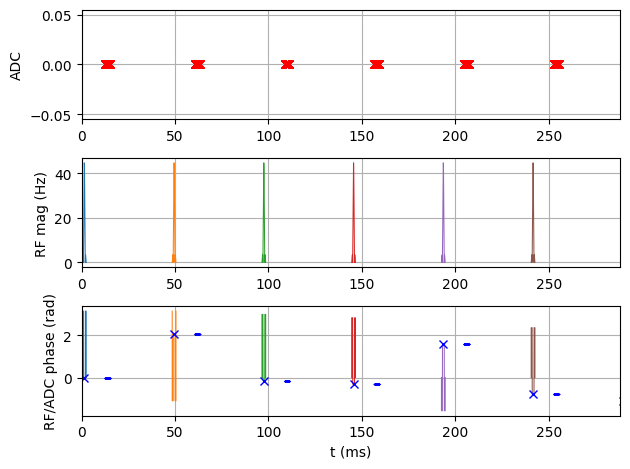

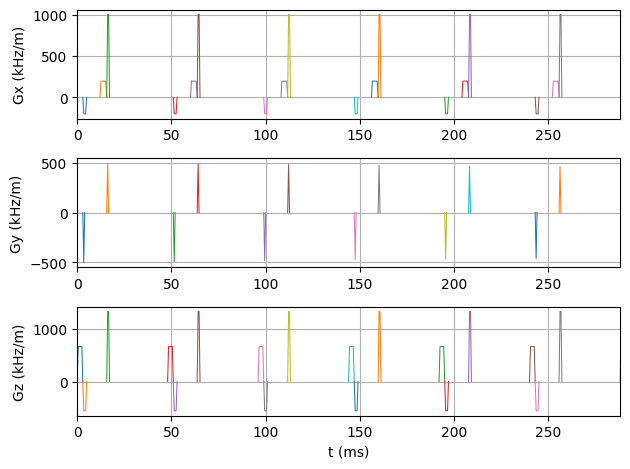

In [5]:
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# Display the sequence
# seq.plot()
nn=6
seq.plot(time_range=np.array([0, nn])*TR, time_disp="ms")

Prepare the sequence output for the scanner
Optional: Here you can download the resulting pulseq .seq file

In [ ]:
experiment_id = '2D_FLASH_Coil_Sensitivity'

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'FL2D')
seq.write(experiment_id + '.seq')

from google.colab import files
files.download(experiment_id + '.seq')  # Download locally

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

On the scanner, run the sequence once using the local receiver coil you want to map and once using the body coil or local transmit coil.

Here, an example data set is read in and coil sensitivities are calculated. Two data sets are available, one phantom and an in vivo data set.

No masking or fitting is used. Thicker slices result in higher SNR.

--2024-02-07 13:34:15--  https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/tutorials/04_hardware_and_imprefections/data/2024-02-06-160115.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1426528 (1.4M) [application/octet-stream]
Saving to: ‘2024-02-06-160115.dat.3’

2024-02-06-160115.d 100%[===================>]   1.36M  --.-KB/s    in 0.04s   

2024-02-07 13:34:15 (34.7 MB/s) - ‘2024-02-06-160115.dat.3’ saved [1426528/1426528]

--2024-02-07 13:34:15--  https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/tutorials/04_hardware_and_imprefections/data/2024-02-06-160052.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuserco

Scan 1/1, read all mdhs: 0.00B [00:00, ?B/s]

read data:   0%|          | 0/128 [00:00<?, ?it/s]

pymapVBVD version 0.5.7
Software version: VD


Scan 1/1, read all mdhs: 0.00B [00:00, ?B/s]

read data:   0%|          | 0/128 [00:00<?, ?it/s]

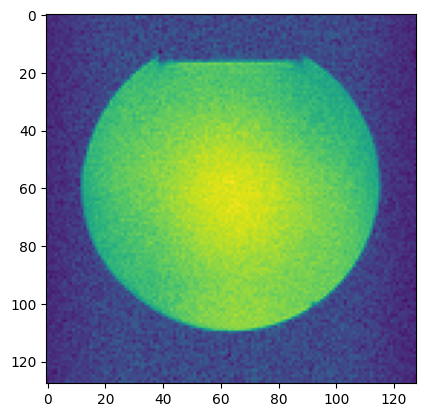

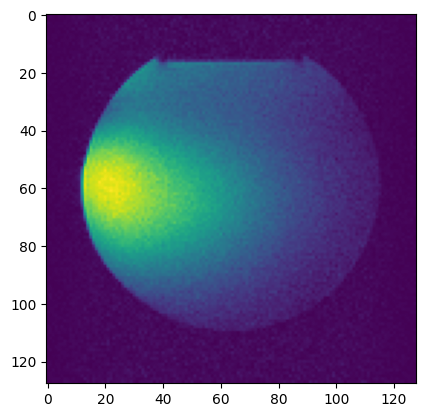

In [18]:
# from inspect import EndOfBlock
# import mapvbvd

def fft_2d(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x, axes=(0,1)), axes=(0,1)), axes=(0,1))
remote_path = "https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/tutorials/04_hardware_and_imprefections/data/"

filename_BC = '2024-02-06-160115.dat' # phantom data
# filename_BC = '2024-02-06-164120.dat' # In Vivo data

filename_LC = '2024-02-06-160052.dat' # phantom data
# filename_LC = '2024-02-06-164128.dat' # In vivo data

!wget {remote_path+filename_BC}
!wget {remote_path+filename_LC}

# Body coil used to transmit

Nc=2
twix_obj = mapvbvd.mapVBVD(filename_BC)
twix_obj.image.removeOS = False
twix_obj.image.disableReflect = True
rawdat = np.transpose(twix_obj.image.unsorted(), (0, 2, 1))
rawdata_BC = np.reshape(rawdat, (Nx, Ny, Nc))

imageBC = np.sqrt(np.sum(np.abs(fft_2d(rawdata_BC)), axis=-1))

plt.figure()
plt.imshow(np.transpose(np.abs(imageBC[::-1,::-1])))



twix_obj = mapvbvd.mapVBVD(filename_LC)
twix_obj.image.removeOS = False
twix_obj.image.disableReflect = True
kdataLC = np.transpose(np.squeeze(twix_obj.image.unsorted()),(0,2,1))

imageLC = fft_2d(kdataLC)

plt.figure()
plt.imshow(np.transpose(np.abs(imageLC[::-1,::-1,1])))


Now divide Local coil image by Body coil image to receive a sensitivity profile
Using sensitivity profiles for reconstructions requires further post-processing (denoising, extrapolation, etc.). One possible tool is Miki Lustigs Espirit toolbox https://github.com/mikgroup/auto-espirit


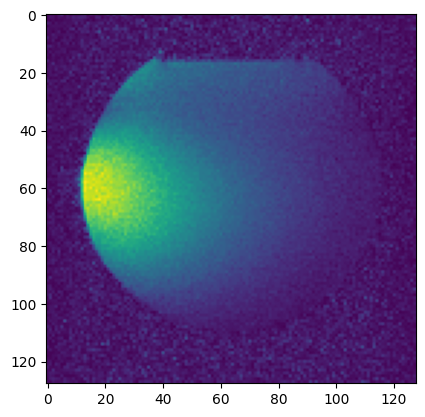

In [14]:
cc=1
image_b1 = imageLC[:,:,cc]/imageBC
plt.figure()
plt.imshow(np.transpose(np.abs(image_b1[::-1,::-1])))#,vmin=0,vmax=0.7)